In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import data, io, transform
import math
from scipy import misc

In [2]:
# Takes in text file of darkNet coords and
# converts [center x, center y, width height]
# to [y_min, x_min, y_max, x_max]

def convert_yolo_2_tf(labels):
    old_boxes = open(labels, 'r')
    old_boxes = old_boxes.read().split('\n')[:-1]
    old_boxes = [i.split() for i in old_boxes]
    for i in old_boxes:
        i[0] = int(i[0])
        for ii in range(1,5):
            i[ii] = float(i[ii])

    #   [batch, number of bounding boxes, coords]
    num_boxes = len(old_boxes)
    boxes = np.zeros([1,num_boxes,4])
    classes = np.zeros([num_boxes])

    for i in range(num_boxes):
        boxes[:,i,0] = (old_boxes[i][2]-old_boxes[i][4]/2)
        boxes[:,i,1] = (old_boxes[i][1]-old_boxes[i][3]/2)
        boxes[:,i,2] = (old_boxes[i][2]+old_boxes[i][4]/2)
        boxes[:,i,3] = (old_boxes[i][1]+old_boxes[i][3]/2)
        classes[i] = old_boxes[i][0]

    return num_boxes, boxes, old_boxes, classes.astype(int)    

In [3]:
num, boxes, old_boxes, classes = convert_yolo_2_tf('labels.txt')

# CROP RANDOM AMOUNT OFF ORIGINAL OBJECT AT RANDOM SCALE

In [4]:
img = mpimg.imread('dice.jpg')
shape = img.shape

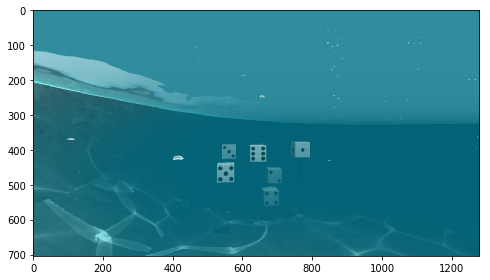

In [5]:
fig = plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

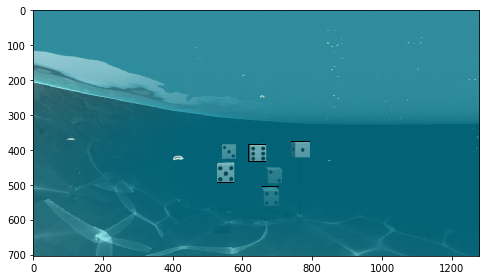

In [6]:
tf_img = tf.convert_to_tensor(np.expand_dims(img,0), np.float32)
box = tf.convert_to_tensor(boxes, np.float32)
test = tf.image.draw_bounding_boxes(tf_img, box)
sess = tf.Session()
image = (sess.run(test))[-1,:,:,:]/255
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

In [7]:
tf_img = tf.reshape(tf_img,[704,1280,3])
begin, size, crop_box = sess.run(tf.image.sample_distorted_bounding_box(
                        image_size = tf.shape(img),
                        bounding_boxes=box,
                        min_object_covered=0.60,
                        aspect_ratio_range=[0.6, 1.4],
                        area_range=[0.2, .5],
                        max_attempts=2000,
                        use_image_if_no_bounding_boxes=False))

In [8]:
image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(tf_img, 0),
                                              box)
image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(tf_img, 0),
                                              crop_box)

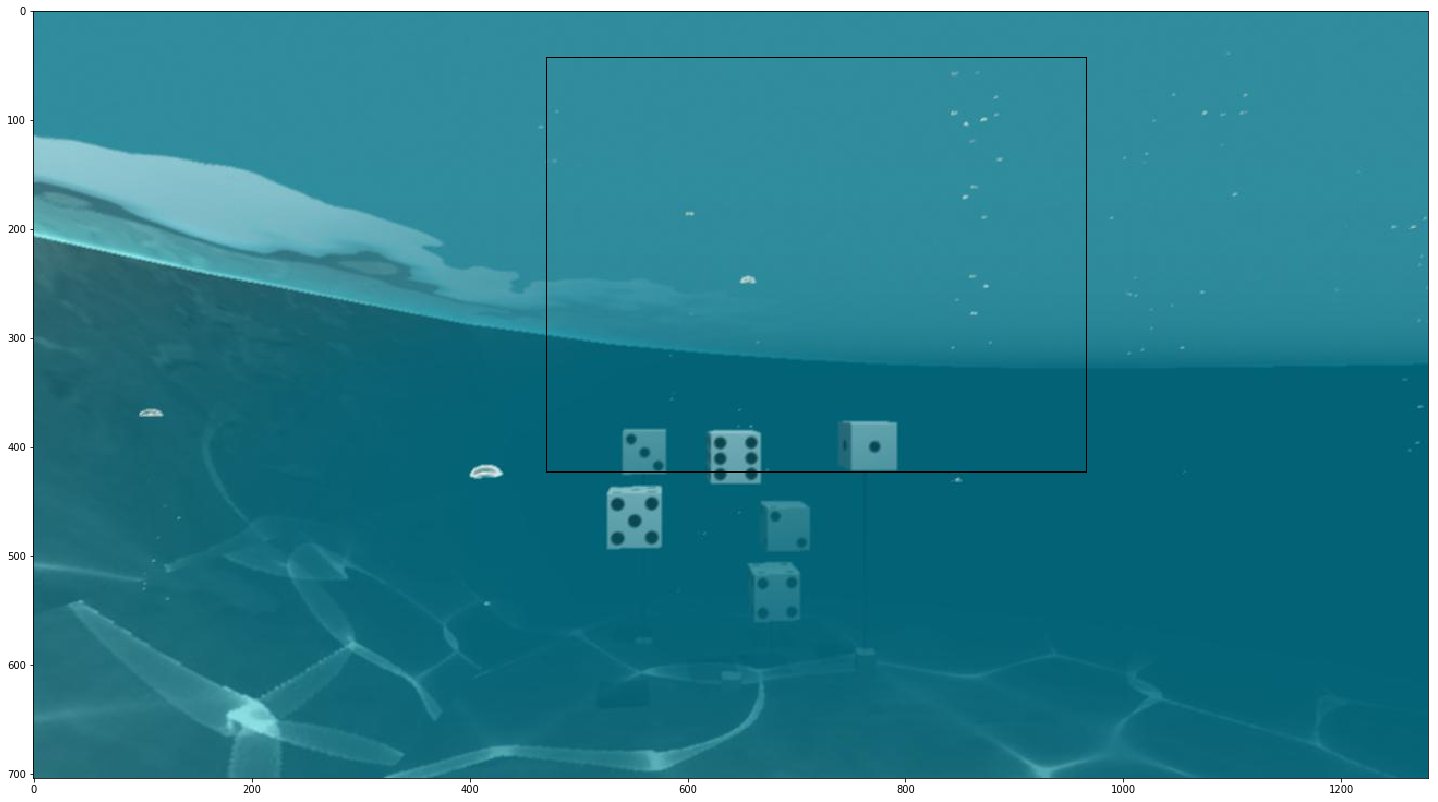

In [9]:
fig = plt.figure(figsize=(8,8))
image = sess.run(image_with_box)
fig = plt.figure(figsize=(25,25))
plt.imshow(image[-1,:,:,:]/255)
plt.show()

In [10]:
# # TODO(JUSTIN) COPY OVER ALL BOXES
# # Wil take newly cropped box from original image and rescale the object box to the newly cropped image.

# old_box = sess.run(box)
# new_box = np.zeros([1,1,4])

# if crop_box[:,:,0] > old_box[:,:,0]:
#     new_box[:,:,0] = 0
# else:
#     new_box[:,:,0] = (old_box[:,:,0] - crop_box[:,:,0]) / (crop_box[:,:,2] - crop_box[:,:,0])

# if crop_box[:,:,2] < old_box[:,:,2]:
#     new_box[:,:,2] = 1
# else:
#     new_box[:,:,2] = (old_box[:,:,2] - crop_box[:,:,0]) / (crop_box[:,:,2] - crop_box[:,:,0])
    
# if crop_box[:,:,1] > old_box[:,:,1]:
#     new_box[:,:,1] = 0
# else:
#     new_box[:,:,1] = (old_box[:,:,1] - crop_box[:,:,1]) / (crop_box[:,:,3] - crop_box[:,:,1])

# if crop_box[:,:,3] < old_box[:,:,3]:
#     new_box[:,:,3] = 1
# else:
#     new_box[:,:,3] = (old_box[:,:,3] - crop_box[:,:,1]) / (crop_box[:,:,3] - crop_box[:,:,1])

In [11]:
distorted_image = sess.run(tf.slice(tf_img, begin, size))
# tf_img = np.expand_dims(distorted_image, axis=0)
# distorted_with_box = tf.image.draw_bounding_boxes(tf_img,new_box)
image = distorted_image

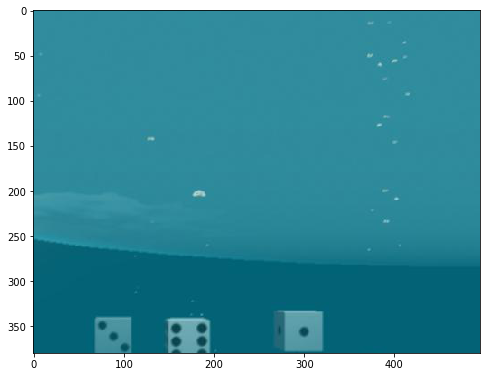

In [12]:
# Randomly Cropped Image w/ New Bounding Box
fig = plt.figure(figsize=(8,8))
plt.imshow(image[:,:,:]/255)
plt.show()

/home/justin/envs/ml/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


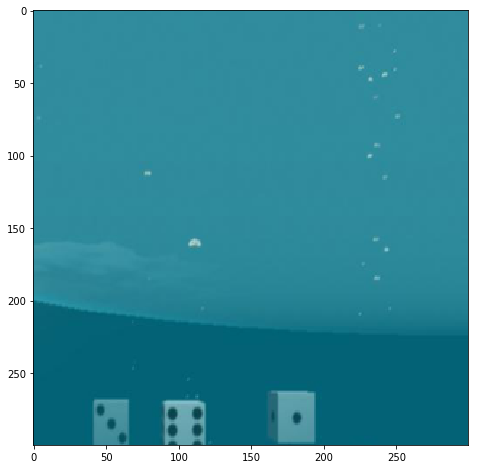

In [13]:
# Darknet / Yolo will resize the bounding box as long as it's in yolo format,
# Cropping and resizing the object adds even more scale image augmentation. A+
fig = plt.figure(figsize=(8,8))
resized = transform.resize(image[:,:,:]/255,[300,300,3])
plt.imshow(resized)
plt.show()

# SCRIPT FOR MAKING IMAGE SQUARE, ROTATING IMAGE AND CALCULATING NEW BOUNDING BOXES

In [14]:
# ORIGINAL IMAGE
img = mpimg.imread('dice.jpg')
shape = img.shape
rot = np.random.randint(-45,45)

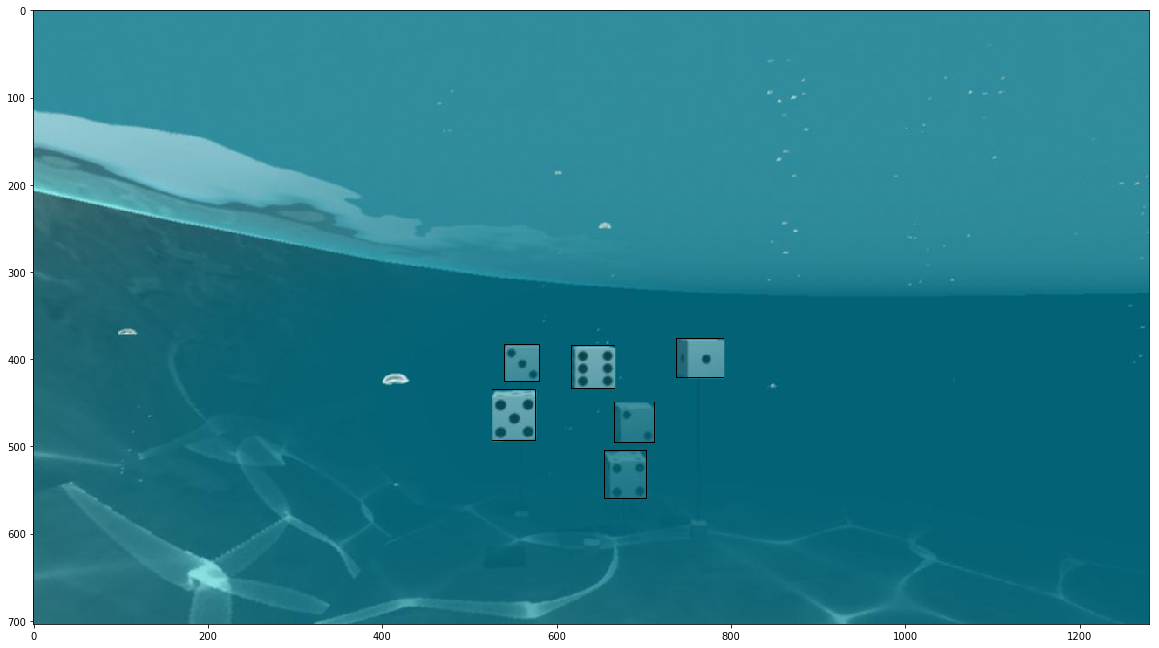

In [15]:
# SHOW ORIGINAL IMAGE WITH BOUNDING BOXES
tf_img = tf.convert_to_tensor(np.expand_dims(img,0), np.float32)
tf_box = tf.convert_to_tensor(boxes, np.float32)
image_with_box = tf.image.draw_bounding_boxes(tf_img,tf_box)
image = sess.run(image_with_box)
fig = plt.figure(figsize=(20,20))
plt.imshow(image[-1,:,:,:]/255)
plt.show()

In [16]:
# BOX FORMAT [ymin,xmin,ymax,xmas]
# CONVERT TF BOUNDING BOXES TO PERCENTAGE \
# W.R.T PADDING TO MAINTAIN EQUAL X & Y SCALE
box_wpads = np.zeros([1,6,4])
x_size = img.shape[1]
y_size = img.shape[0]
max_size = max(x_size, y_size)
x_padding = (max_size-x_size)/2
y_padding = (max_size-y_size)/2
box_wpads[:,:,1] = (x_padding+boxes[:,:,1]*x_size) / max(x_size, y_size)
box_wpads[:,:,3] = (x_padding+boxes[:,:,3]*x_size) / max(x_size, y_size)
box_wpads[:,:,0] = (y_padding+boxes[:,:,0]*y_size) / max(x_size, y_size)
box_wpads[:,:,2] = (y_padding+boxes[:,:,2]*y_size) / max(x_size, y_size)

In [17]:
# RESIZE IMAGE WITH EDGE REPEATED PADDING
# TODO() ADD LEFT AND RIGHT PAD
top_edge = img[0,:,:]
bottom_edge = img[-1,:,:]
left_edge = img[:,0,:]
right_edge = img[:,-1,:]
top_edge = np.expand_dims(top_edge,0)
bottom_edge = np.expand_dims(bottom_edge,0)
top_pad = np.tile(top_edge, (int(y_padding),1,1))
bottom_pad = np.tile(bottom_edge, (int(y_padding),1,1))
left_pad = np.tile(left_edge, (1,int(x_padding),1))
right_pad = np.tile(right_edge, (int(x_padding),1,1))

if y_padding != 0:
    padded_image = np.vstack([top_pad,img])
    padded_image = np.vstack([padded_image, bottom_pad])
if x_padding != 0:
    padded_image = np.hstack([left_pad,img])
    padded_image = np.vstack([padded_image, right_pad])

In [18]:
# SHOW BOUNDING BOXES WITH NEW PADDED IMAGE
tf_img = tf.convert_to_tensor(np.expand_dims(padded_image,0), np.float32)
tf_box = tf.convert_to_tensor(box_wpads, np.float32)
image_with_box = tf.image.draw_bounding_boxes(tf_img,tf_box)

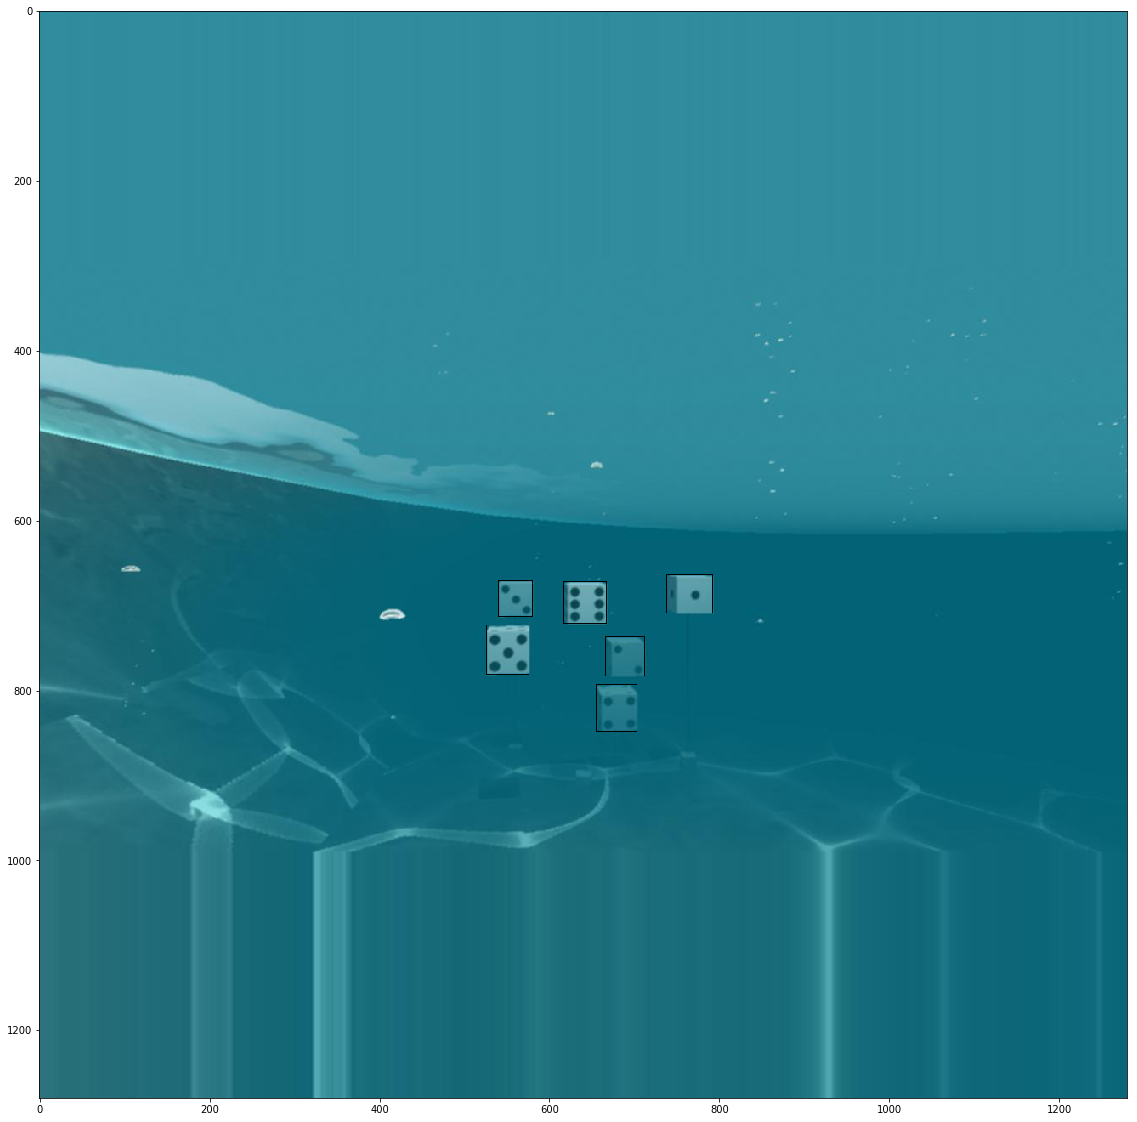

In [19]:
fig = plt.figure(figsize=(20,20))
image = sess.run(image_with_box)
plt.imshow(image[-1,:,:,:]/255)
plt.show()

In [20]:
# GET MIN / MAX'S AND CONVERT INTO 4 POINTS 
# CONVERT FROM [ymin,xmin,ymax,xmas]
# TO FORMAT [[X,Y],[X,Y],[X,Y],[X,Y]]
#             TL    BL    TR     BR           
def get_all_points(boxes):
    boxes = boxes[-1,:,:]
    all_points = []
    for i in range(len(classes)):
        points=[[boxes[i,1],boxes[i,0]],
                [boxes[i,1],boxes[i,2]],
                [boxes[i,3],boxes[i,0]],
                [boxes[i,3],boxes[i,2]]]
        all_points.append(points)
    return np.asarray(all_points)

all_points = get_all_points(box_wpads)

# CONVERT ARRAY FORM TO CARTESIAN PLANE
all_points = all_points-0.5
all_points[:,:,1] = -all_points[:,:,1]

In [21]:
rotated = transform.rotate(padded_image,rot, mode='edge')
rads = np.deg2rad(rot)
rotation_matrix = np.array([[np.cos(rads), -np.sin(rads)],
                            [np.sin(rads), np.cos(rads)]])

def rotate_points(all_points):
    new_points = []
    for i in range(len(classes)):
        points = np.zeros([2])
        for ii in range(4):
            new_point = np.matmul(rotation_matrix,all_points[i,ii,:])
            points = np.vstack((points,new_point))
        new_points.append(points[1:,:])
    return np.asarray(new_points)

new_points = rotate_points(all_points)
new_points[:,:,1] = -new_points[:,:,1]
new_points[:,:,0] = new_points[:,:,0] + 0.5 #(img.shape[1]/rotated.shape[0])/2
new_points[:,:,1] = new_points[:,:,1] + 0.5 #(img.shape[0]/rotated.shape[1])/2

In [22]:
all_boxes = np.zeros([4])
for i in range(len(classes)):
    box = [np.min(new_points[i,:,1]),np.min(new_points[i,:,0]),np.max(new_points[i,:,1]),np.max(new_points[i,:,0])]
    all_boxes = np.vstack((all_boxes,box))
all_boxes = all_boxes[1:,:]

In [23]:
tf_img = tf.convert_to_tensor(np.expand_dims(rotated,0), np.float32)
tf_box = tf.convert_to_tensor(np.expand_dims(all_boxes,0), np.float32)
image_with_box = tf.image.draw_bounding_boxes(tf_img,tf_box)
image = sess.run(image_with_box)

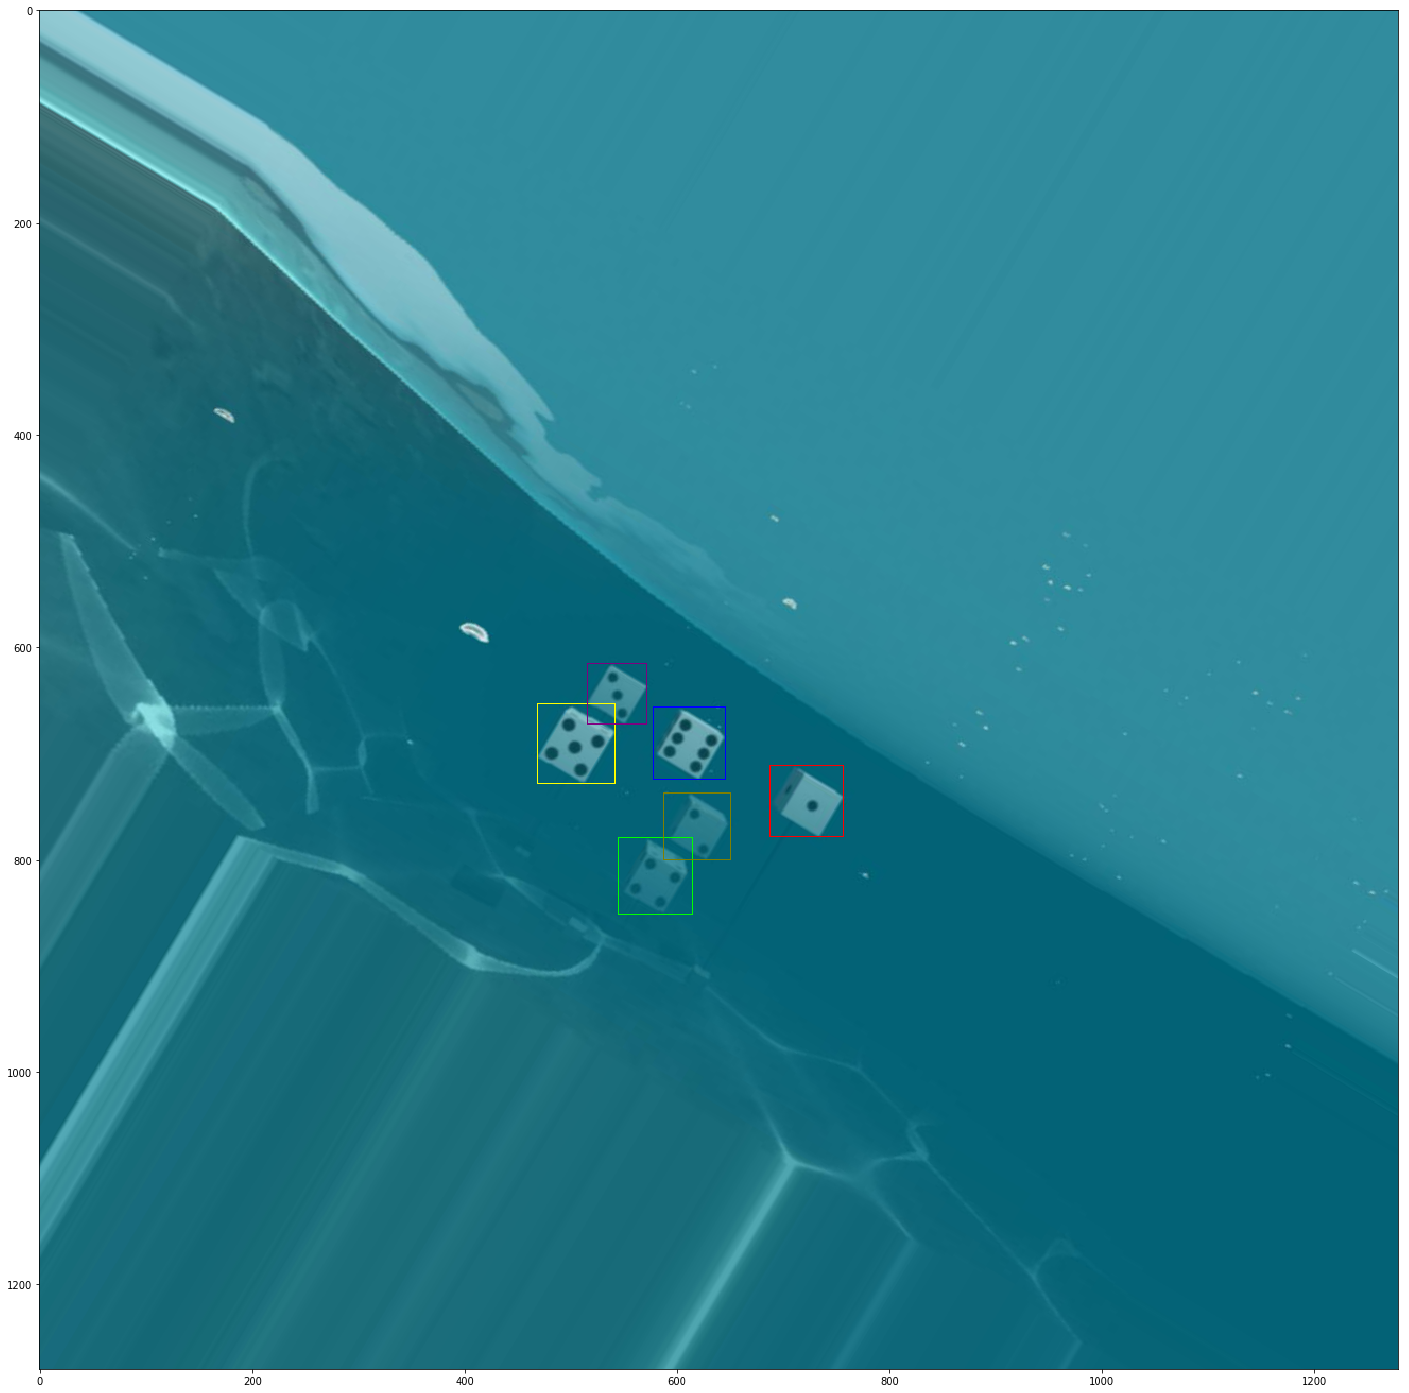

In [24]:
fig = plt.figure(figsize=(25,25))
plt.imshow(image[-1,:,:,:])
plt.show()

In [25]:
# TODO() POSSIBLY ONCE ROTATED RETURN A CROPPED IMAGE CONTAINING ALL BOUNDING BOX IMAGES
# TODO() RATHER THEN ADDING PADDING GET NEW BOUNDING BOXES W.R.T TO PADDING, ROTATE THE IMAGE ...
# WITH RESIZE='TRUE' AND MAINTAIN ORIGINAL IMAGE BY ADDING EDGE PIXELS TO THE NEW ROTATED SHAPE ...
# THEN RESCALE BOUNDING BOXES TO NEW IMAGE SHAPE W.R.T TO ADDED PIXELS BASED ON ROTATION ANGLE